Name: Arya Sun
<br>
Github Username: fearofhelicopter
<br>
USC ID: 8111052837

## 1. Tree-Based Methods

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, auc, roc_curve, confusion_matrix, classification_report, mean_squared_error
from sklearn.utils import resample

import xgboost as xgb
from xgboost import cv
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE

import operator

### (a) Download the APS Failure data
Download the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [2]:
dfTrain = pd.read_csv('../data/aps_failure_training_set.csv', skiprows = 20)
dfTest = pd.read_csv('../data/aps_failure_test_set.csv', skiprows = 20)

dfTrain_Y = dfTrain["class"]
dfTrain_X = dfTrain.drop("class", axis=1)

dfTest_Y = dfTest["class"]
dfTest_X = dfTest.drop("class", axis=1)

for col in dfTrain_X.columns:
    dfTrain_X[col] = dfTrain_X[col].apply(lambda x: float(x) if x != "na" else np.nan)

for col in dfTest_X.columns:
    dfTest_X[col] = dfTest_X[col].apply(lambda x: float(x) if x != "na" else np.nan)

dfTrain_X = dfTrain_X.fillna(dfTrain_X.mean())
dfTest_X = dfTest_X.fillna(dfTest_X.mean())
df = pd.concat([dfTrain_X, dfTest_X], ignore_index=True)

df

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.0,0.713189,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,33058.0,0.713189,0.000000e+00,190620.639314,0.0,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,41040.0,0.713189,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,12.0,0.000000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,318.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,60874.0,0.713189,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,81852.0,0.772065,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,18.0,0.000000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,79636.0,0.772065,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,110.0,0.772065,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


### (b) Data Preparation
This data set has missing values. When the number of data with missing values is significant, discarding them is not a good idea.

#### (i) Research what types of techniques are usually used
for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

Data Imputation: using a model toreplace missing values.

1. A constant value that has meaning within the domain, such as 0, distinct from all other values. This works for categorical features.
2. A feature value from another randomly selected observation.
3. A statistics such as mean, median or mode value of the feature/column.
4. A value estimated by another predictive model:
    
    • Treat the missing value as the output of your predictive model
    
    • Predict it based on other data points that do not have missing values
        
        • Examples: KNN regression and classification and Linear Regression
    
    • An iterative method based on Expectation Maximization can be used:
        
        • First, impute all missing values randomly or using mean or median
        • Predict missing values using other data points
        • Update all missing values and iterate

#### (ii) Calculate the coefficient of variation
For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [3]:
cv_table = df.apply(lambda x: x.std() / x.mean()).to_frame(name = 'CV')

cv_table

,CV
aa_000,4.328608
ab_000,2.178397
ac_000,2.167648
ad_000,206.786809
ae_000,22.293998
...,...
ee_007,4.885086
ee_008,3.335019
ee_009,5.753917
ef_000,47.925135


#### (iii) Plot a correlation matrix
Plot a correlation matrix for your features using pandas or any other tool.

In [4]:
corr_matrix = df.corr()

corr_matrix

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019908,-0.011646,-0.000574,0.025784,0.035977,0.011681,0.076379,0.195163,0.307445,...,0.414127,0.419914,0.409662,0.419784,0.425682,0.356969,0.259670,0.133764,0.006660,0.010344
ab_000,0.019908,1.000000,-0.010893,0.000026,0.024889,0.043279,0.000557,0.006667,0.023633,0.035837,...,0.025249,0.037150,0.028872,0.034329,0.024029,0.013594,0.002437,0.000527,0.046882,0.075719
ac_000,-0.011646,-0.010893,1.000000,-0.002032,-0.004769,-0.010612,0.015535,-0.002333,-0.009436,-0.022885,...,-0.009806,-0.006434,-0.007958,-0.008110,-0.014677,-0.018630,0.010436,0.017292,-0.006192,0.015826
ad_000,-0.000574,0.000026,-0.002032,1.000000,-0.000193,-0.000234,-0.000041,-0.000054,-0.000123,-0.000256,...,-0.000901,-0.000942,-0.000932,-0.000761,-0.000767,-0.000469,-0.000805,-0.000503,-0.000082,-0.000091
ae_000,0.025784,0.024889,-0.004769,-0.000193,1.000000,0.829986,-0.000441,-0.000609,0.001946,0.020674,...,0.012750,0.019440,0.012845,0.026435,0.066532,0.036618,-0.008391,-0.006949,0.063587,0.030854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.356969,0.013594,-0.018630,-0.000469,0.036618,0.046481,0.007631,0.068003,0.181968,0.475571,...,0.442199,0.432911,0.419633,0.380132,0.543449,1.000000,0.227099,0.063065,-0.000312,0.000948
ee_008,0.259670,0.002437,0.010436,-0.000805,-0.008391,-0.010839,0.000067,0.005354,0.009112,0.020687,...,0.442533,0.470574,0.448390,0.394021,0.365686,0.227099,1.000000,0.690147,-0.005169,-0.001952
ee_009,0.133764,0.000527,0.017292,-0.000503,-0.006949,-0.008533,-0.001103,-0.003539,-0.009088,-0.018163,...,0.224587,0.235844,0.220785,0.183844,0.158590,0.063065,0.690147,1.000000,-0.003161,-0.001063
ef_000,0.006660,0.046882,-0.006192,-0.000082,0.063587,0.093474,-0.000076,0.001133,0.005610,0.011018,...,0.003711,0.010169,0.002979,0.026910,0.005291,-0.000312,-0.005169,-0.003161,1.000000,0.222579


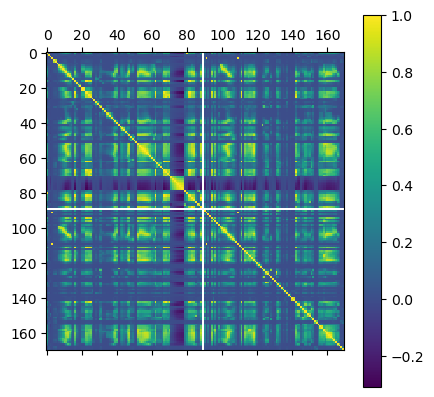

In [5]:
plt.matshow(corr_matrix)
plt.colorbar()
plt.show()

#### (iv) Make scatter plots and box plots
Pick ⌊√170⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

In [6]:
#sqrt(170) = 13
cv_table.sort_values(by = 'CV', ascending = False, inplace = True)
top_features = cv_table.head(13)

top_features

,CV
cf_000,207.335930
co_000,206.941549
ad_000,206.786809
cs_009,192.498194
dj_000,122.169994
as_000,113.895899
dh_000,112.666588
df_000,111.279258
ag_000,91.465520
au_000,86.090347


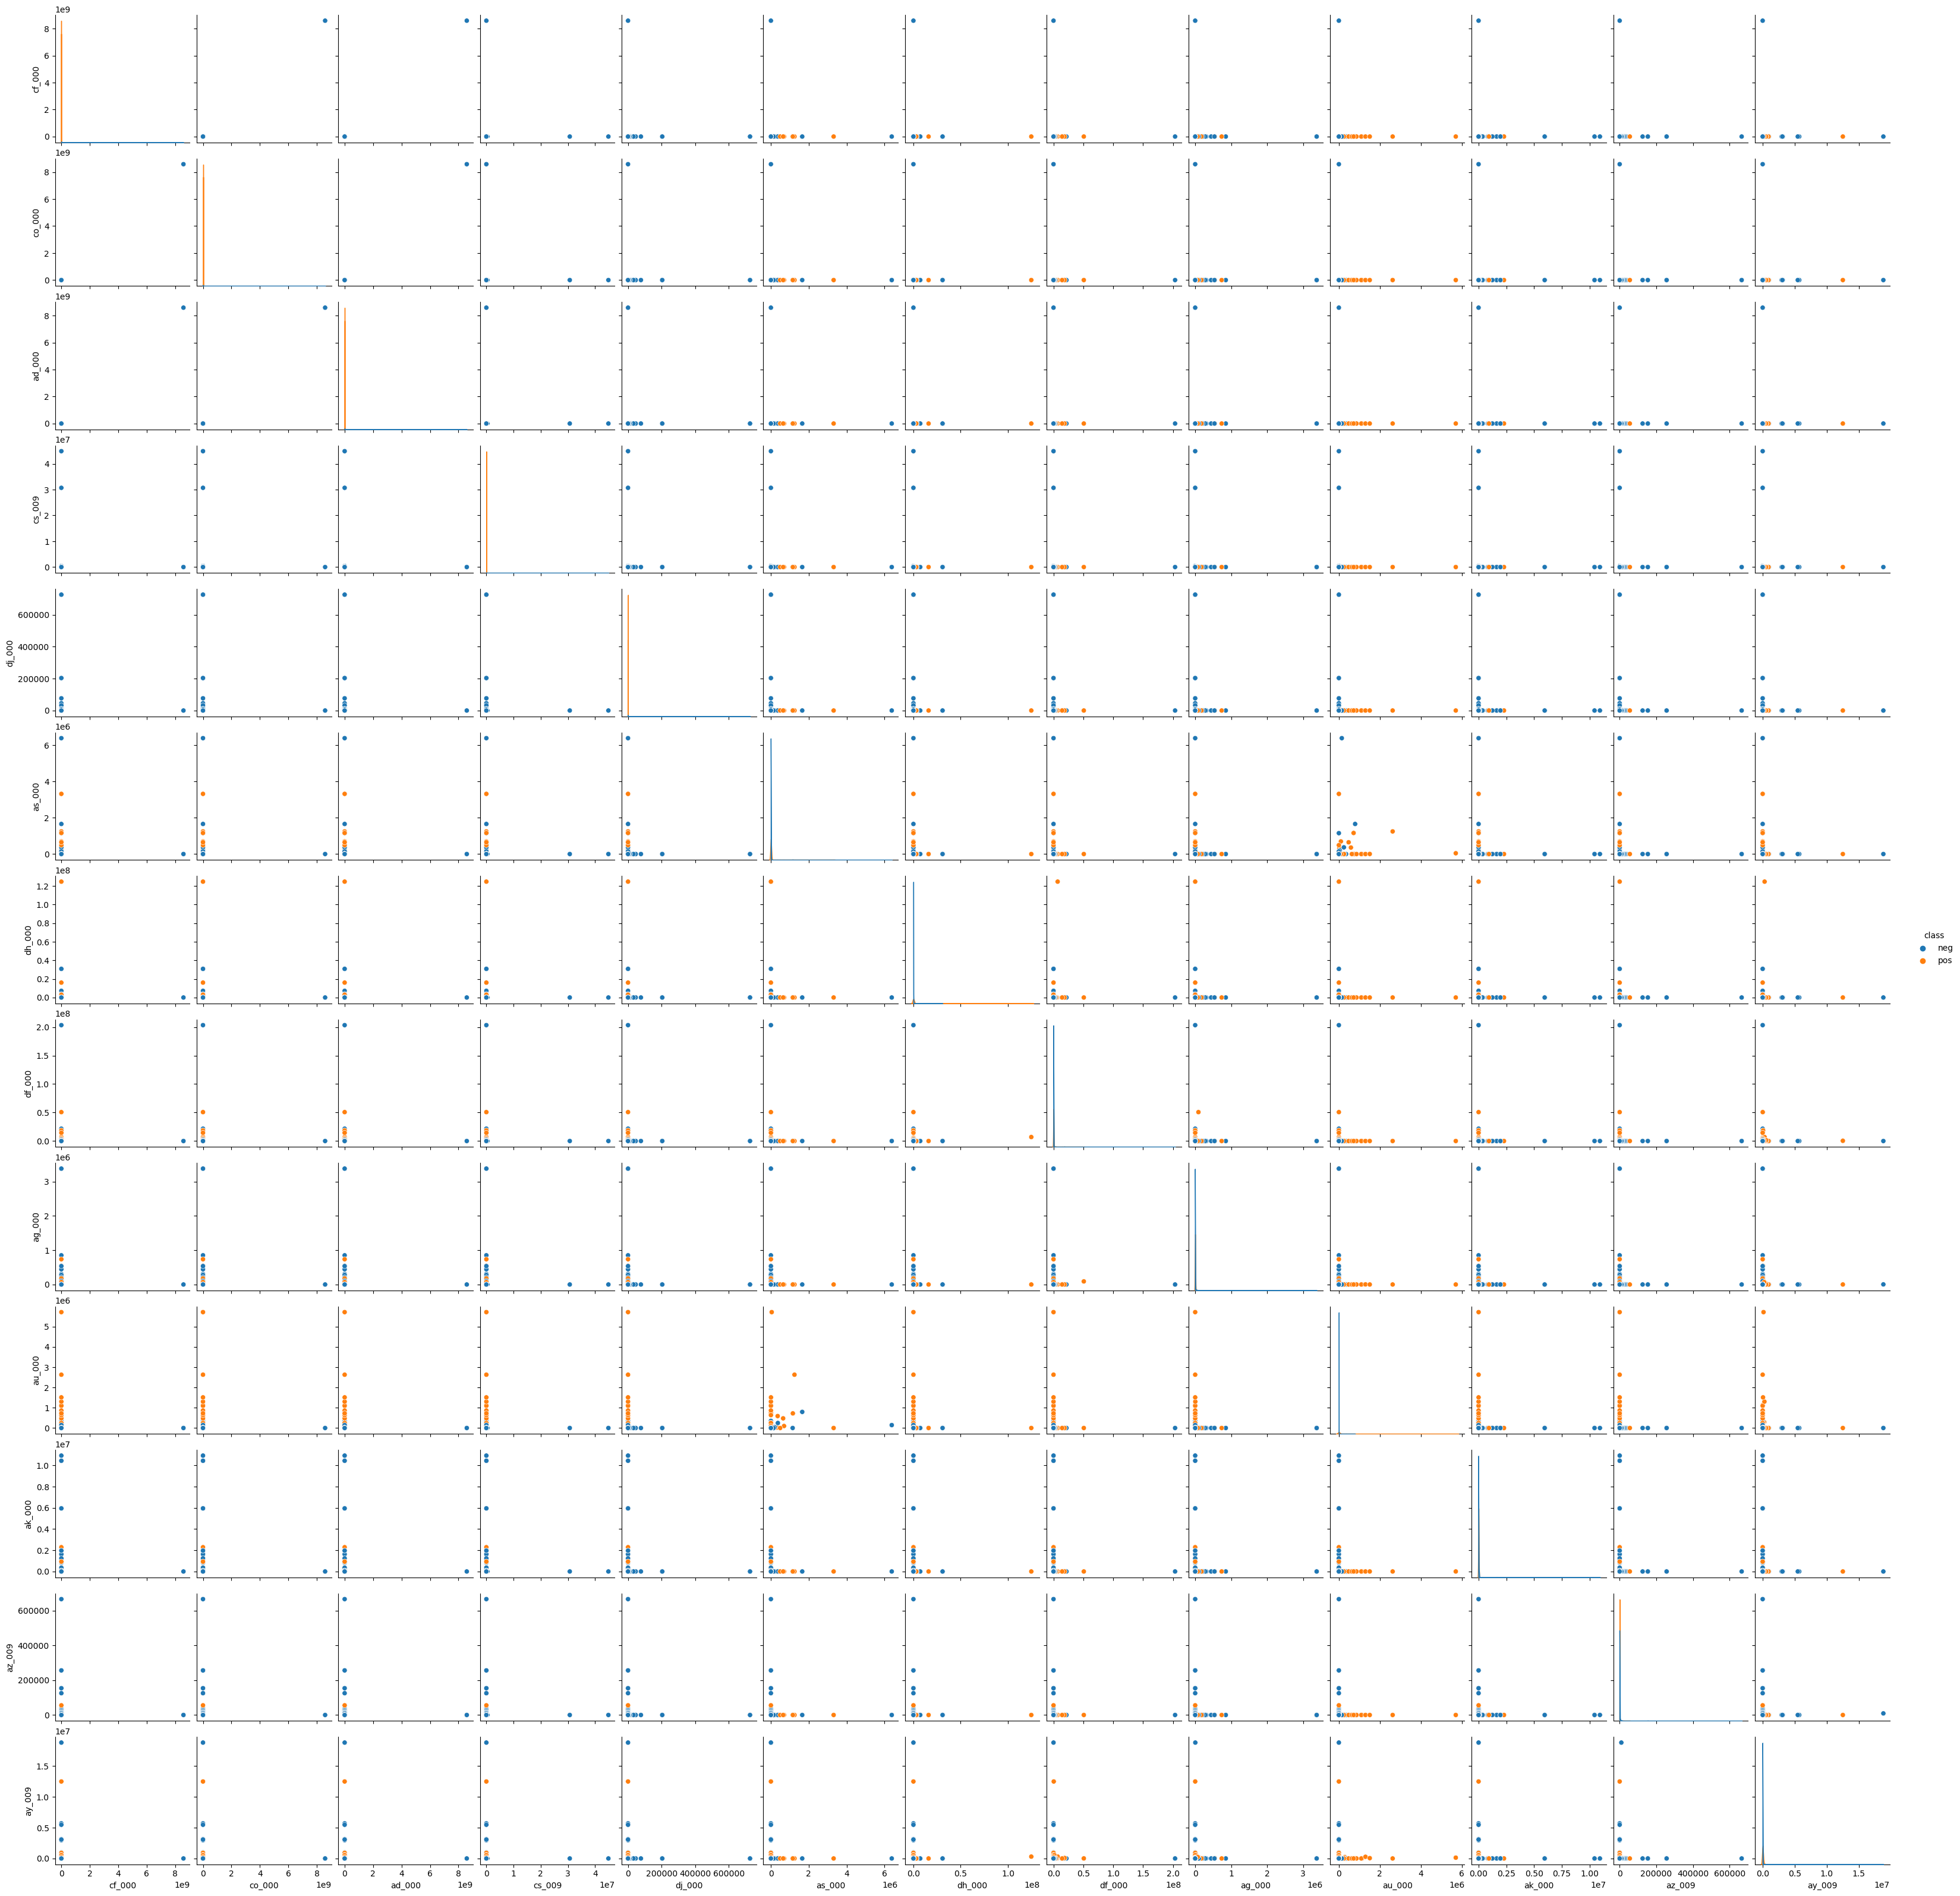

In [7]:
df['class'] = pd.concat([dfTrain_Y, dfTest_Y], ignore_index = True)

sns.pairplot(data = df, vars = top_features.index, hue = 'class')

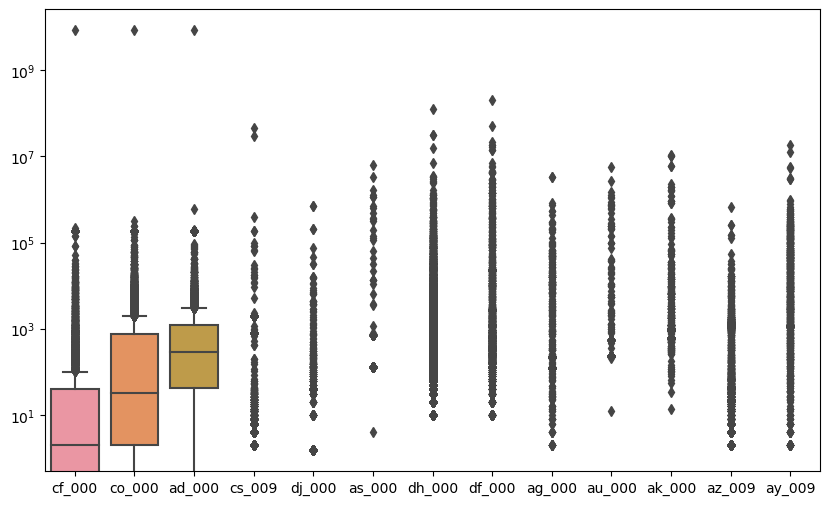

In [8]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.boxplot(data=df[top_features.index], ax = ax)
ax.set_yscale('log')

Cannot draw conclusions about significance of those features just by the scatter plots.

The scatterplot suggests that some feature pairs are linearly separable, which could potentially indicate that these features are good predictors of class label. However, the scatterplot and boxplot may not be particularly informative due to the high number of zero values and very high non-zero values of the attributes.

#### (v) Is this data set imbalanced?
Determine the number of positive and negative data.

In [9]:
print(df["class"].value_counts())

neg    74625
pos     1375
Name: class, dtype: int64


Yes, it is.

### (c) Train a random forest
to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[59000     0]
 [    0  1000]]
Misclassification rate: 0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     59000
         1.0       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



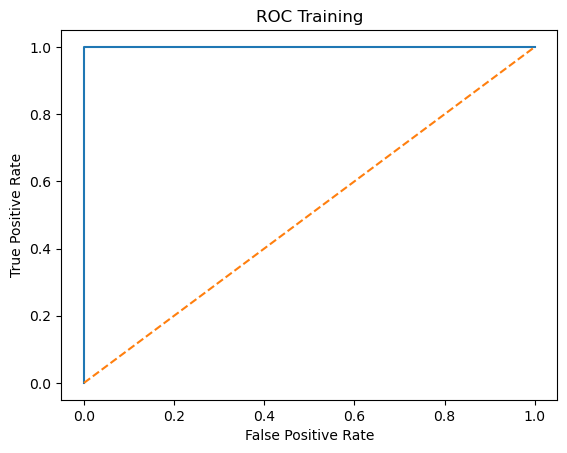

ROC_AUC:  0.8579946666666667
AUC:  0.8579946666666667
the confusion matrix:
 [[15604    21]
 [  106   269]]
Misclassification rate: 0.0079375
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.93      0.72      0.81       375

    accuracy                           0.99     16000
   macro avg       0.96      0.86      0.90     16000
weighted avg       0.99      0.99      0.99     16000



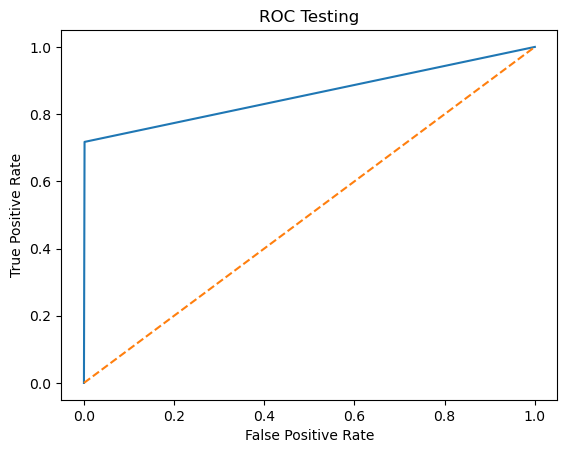

oob_error: 0.006033333333333335
test error: 0.007937500000000042


In [10]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, oob_score = True)
clf_rf.fit(dfTrain_X, dfTrain_Y)

#training#
pred_train = clf_rf.predict(dfTrain_X)

pred_training = np.zeros(len(pred_train))
pred_training[pred_train != "neg"] = 1.0

true_training = np.zeros(len(dfTrain_Y.values))
true_training[dfTrain_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_training, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#testing#
pred_test = clf_rf.predict(dfTest_X)

pred_testing = np.zeros(len(pred_test))
pred_testing[pred_test != "neg"] = 1.0

true_testing = np.zeros(len(dfTest_Y.values))
true_testing[dfTest_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

#compare oob error#
oob_error = 1 - clf_rf.oob_score_
print("oob_error: {}".format(oob_error))
print("test error: {}".format(1 - accuracy_score(true_testing, pred_testing)))

### (d) Research class imbalance in random forest
Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[59000     0]
 [    0  1000]]
Misclassification rate: 0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     59000
         1.0       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



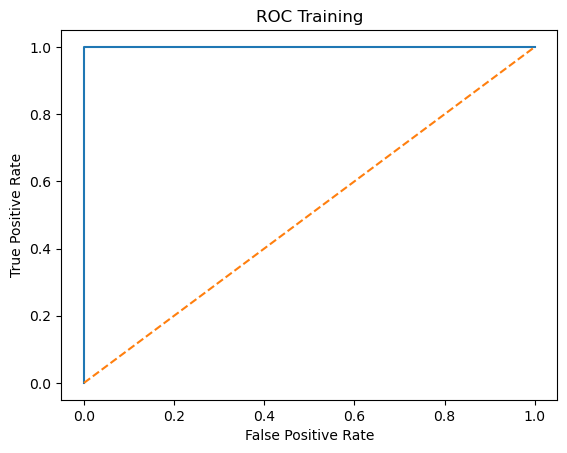

ROC_AUC:  0.7743786666666665
AUC:  0.7743786666666665
the confusion matrix:
 [[15616     9]
 [  169   206]]
Misclassification rate: 0.011125
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     15625
         1.0       0.96      0.55      0.70       375

    accuracy                           0.99     16000
   macro avg       0.97      0.77      0.85     16000
weighted avg       0.99      0.99      0.99     16000



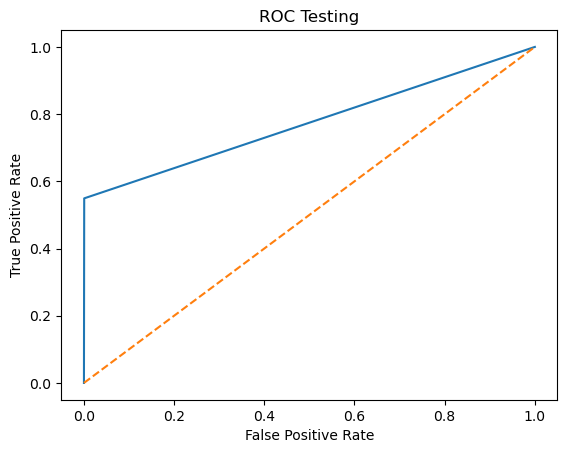

oob_error: 0.007816666666666694
test error: 0.011125000000000052


In [11]:
#class weighting#
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, oob_score = True, class_weight="balanced")
clf_rf.fit(dfTrain_X, dfTrain_Y)

#training#
pred_train = clf_rf.predict(dfTrain_X)

pred_training = np.zeros(len(pred_train))
pred_training[pred_train != "neg"] = 1.0

true_training = np.zeros(len(dfTrain_Y.values))
true_training[dfTrain_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_training, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#testing#
pred_test = clf_rf.predict(dfTest_X)

pred_testing = np.zeros(len(pred_test))
pred_testing[pred_test != "neg"] = 1.0

true_testing = np.zeros(len(dfTest_Y.values))
true_testing[dfTest_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

#compare oob error#
oob_error = 1 - clf_rf.oob_score_
print("oob_error: {}".format(oob_error))
print("test error: {}".format(1 - accuracy_score(true_testing, pred_testing)))

neg    1000
pos    1000
Name: Y, dtype: int64
ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[1000    0]
 [   0 1000]]
Misclassification rate: 0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



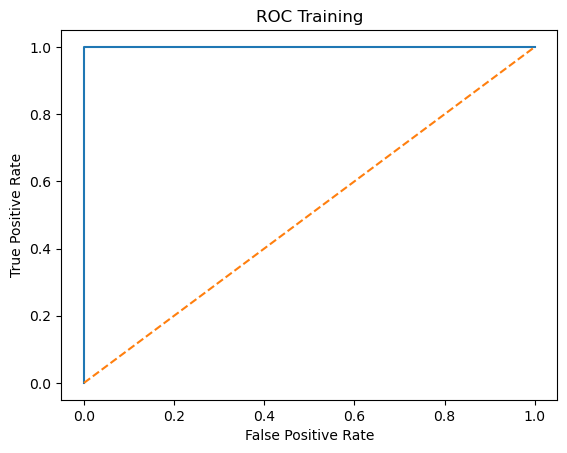

ROC_AUC:  0.9644373333333334
AUC:  0.9644373333333334
the confusion matrix:
 [[14847   778]
 [    8   367]]
Misclassification rate: 0.049125
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97     15625
         1.0       0.32      0.98      0.48       375

    accuracy                           0.95     16000
   macro avg       0.66      0.96      0.73     16000
weighted avg       0.98      0.95      0.96     16000



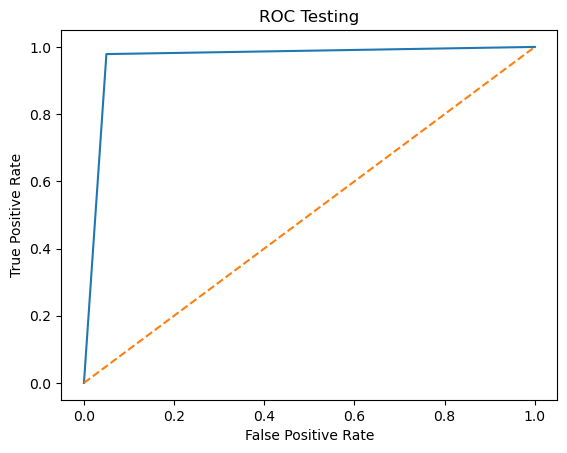

oob_error: 0.04349999999999998
test error: 0.049124999999999974


In [12]:
#Subsampling (Down-sampling)#
df_majority = dfTrain_X[dfTrain_Y == "neg"].copy()
df_minority = dfTrain_X[dfTrain_Y == "pos"].copy()

df_majority.loc[:, "Y"] = "neg"
df_minority.loc[:, "Y"] = "pos"

df_majority_downsample = resample(df_majority,
                                   replace = False,
                                   n_samples = len(df_minority),
                                   random_state = 123)

dfTrain_X_down = pd.concat([df_majority_downsample, df_minority])

dfTrain_Y_down = dfTrain_X_down["Y"]
dfTrain_X_down = dfTrain_X_down.drop("Y", axis = 1)

print(dfTrain_Y_down.value_counts())

clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 0, oob_score = True)
clf_rf.fit(dfTrain_X_down, dfTrain_Y_down)

#training#
pred_train = clf_rf.predict(dfTrain_X_down)

pred_training = np.zeros(len(pred_train))
pred_training[pred_train != "neg"] = 1.0

true_training = np.zeros(len(dfTrain_Y_down.values))
true_training[dfTrain_Y_down.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_training, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#testing#
pred_test = clf_rf.predict(dfTest_X)

pred_testing = np.zeros(len(pred_test))
pred_testing[pred_test != "neg"] = 1.0

true_testing = np.zeros(len(dfTest_Y.values))
true_testing[dfTest_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

#compare oob error#
oob_error = 1 - clf_rf.oob_score_
print("oob_error: {}".format(oob_error))
print("test error: {}".format(1 - accuracy_score(true_testing, pred_testing)))

neg    59000
pos    59000
Name: Y, dtype: int64
ROC_AUC:  1.0
AUC:  1.0
the confusion matrix:
 [[59000     0]
 [    0 59000]]
Misclassification rate: 0.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     59000
         1.0       1.00      1.00      1.00     59000

    accuracy                           1.00    118000
   macro avg       1.00      1.00      1.00    118000
weighted avg       1.00      1.00      1.00    118000



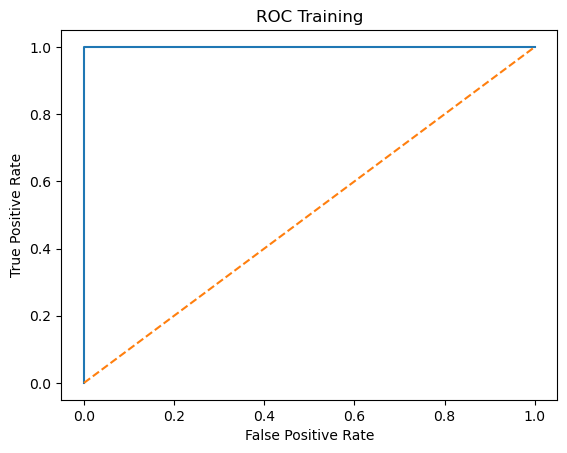

ROC_AUC:  0.8377386666666667
AUC:  0.8377386666666667
the confusion matrix:
 [[15596    29]
 [  121   254]]
Misclassification rate: 0.009375
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.90      0.68      0.77       375

    accuracy                           0.99     16000
   macro avg       0.94      0.84      0.88     16000
weighted avg       0.99      0.99      0.99     16000



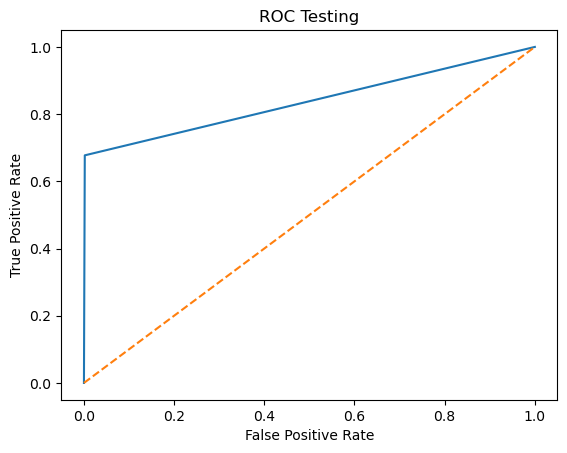

oob_error: 0.000957627118644111
test error: 0.009375000000000022


In [13]:
#Upsampling#
df_majority = dfTrain_X[dfTrain_Y == "neg"].copy()
df_minority = dfTrain_X[dfTrain_Y == "pos"].copy()

df_majority.loc[:, "Y"] = "neg"
df_minority.loc[:, "Y"] = "pos"

df_minority_upsample = resample(df_minority,
                                 replace = True,
                                 n_samples = len(df_majority),
                                 random_state = 123)

dfTrain_X_upsample = pd.concat([df_majority, df_minority_upsample])

dfTrain_Y_upsample = dfTrain_X_upsample["Y"]
dfTrain_X_upsample = dfTrain_X_upsample.drop("Y", axis=1)

print(dfTrain_Y_upsample.value_counts())

clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)
clf_rf.fit(dfTrain_X_upsample, dfTrain_Y_upsample)

#training#
pred_train = clf_rf.predict(dfTrain_X_upsample)

pred_training = np.zeros(len(pred_train))
pred_training[pred_train != "neg"] = 1.0

true_training = np.zeros(len(dfTrain_Y_upsample.values))
true_training[dfTrain_Y_upsample.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_training, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#testing#
pred_test = clf_rf.predict(dfTest_X)

pred_testing = np.zeros(len(pred_test))
pred_testing[pred_test != "neg"] = 1.0

true_testing = np.zeros(len(dfTest_Y.values))
true_testing[dfTest_Y.values != "neg"] = 1.0

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

#compare oob error#
oob_error = 1 - clf_rf.oob_score_
print("oob_error: {}".format(oob_error))
print("test error: {}".format(1 - accuracy_score(true_testing, pred_testing)))

Class imbalance in random forests has the lower error rate.

### (e) XGBoost and Model Trees
In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has ΣjβjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node.
One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

In [14]:
alpha_cv_dict = {}

for alpha in [1, 5, 10]:

    params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                    'max_depth': 5, 'alpha': alpha}

    data_dmatrix = xgb.DMatrix(data = dfTrain_X, label = dfTrain_Y.apply(lambda x: 0 if x == "neg" else 1))

    xgb_cv = cv(dtrain = data_dmatrix, params = params, nfold = 5,
                num_boost_round = 50, early_stopping_rounds = 10, 
                metrics = "auc", as_pandas = True, seed = 123)

    alpha_cv_dict[alpha] = xgb_cv["test-auc-mean"].max()

alpha_cv_dict_d = dict(sorted(alpha_cv_dict.items(), key = operator.itemgetter(1),reverse = True))

best_alpha = list(alpha_cv_dict_d.keys())[0]
print("best_alpha: ", best_alpha)

#use best alpha#
params["alpha"] = best_alpha
xgbClf = XGBClassifier(**params)

xgbModel = xgbClf.fit(dfTrain_X, dfTrain_Y.apply(lambda x: 0 if x == "neg" else 1))

best_alpha:  1


ROC_AUC:  0.9474322033898305
AUC:  0.9474322033898305
the confusion matrix:
 [[58992     8]
 [  105   895]]
Misclassification rate: 0.0018833333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       0.99      0.90      0.94      1000

    accuracy                           1.00     60000
   macro avg       0.99      0.95      0.97     60000
weighted avg       1.00      1.00      1.00     60000



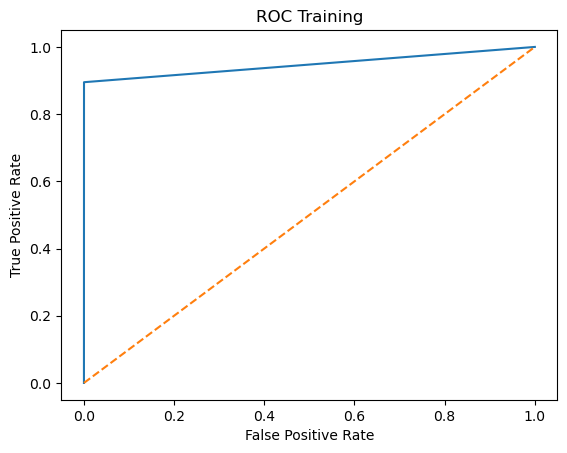

ROC_AUC:  0.8715200000000001
AUC:  0.8715200000000001
the confusion matrix:
 [[15610    15]
 [   96   279]]
Misclassification rate: 0.0069375
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.95      0.74      0.83       375

    accuracy                           0.99     16000
   macro avg       0.97      0.87      0.92     16000
weighted avg       0.99      0.99      0.99     16000



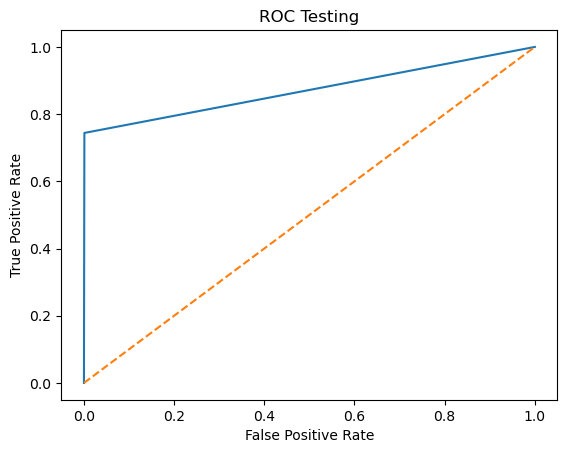

XGBoost test MSE:  0.0069375


In [15]:
#Training#
pred_training = xgbModel.predict(dfTrain_X)

true_training_all = dfTrain_Y.apply(lambda x: 0 if x == "neg" else 1)

roc_auc = roc_auc_score(true_training_all, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training_all, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training_all, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training_all, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#Testing#
pred_testing = xgbModel.predict(dfTest_X)

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

# Compute the MSE between the true labels and the predicted labels#
mse = mean_squared_error(true_testing, pred_testing)
print("XGBoost test MSE: ", mse)

### (f) Use SMOTE to pre-process your data
to compensate for class imbalance. Train XGBosst with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross validation here. Compare the uncompensated case with SMOTE case.

In [16]:
oversample = SMOTE()
dfTrain_X_smote, y_smote = oversample.fit_resample(dfTrain_X, dfTrain_Y)

alpha_cv_dict = {}

for alpha in [1,5,10]:

    params = {"objective":"binary:logistic", 'colsample_bytree': 0.3, 'learning_rate': 0.1,
                    'max_depth': 5, 'alpha': alpha}

    data_dmatrix = xgb.DMatrix(data = dfTrain_X_smote, label = y_smote.apply(lambda x: 0 if x == "neg" else 1))

    xgb_cv = cv(dtrain = data_dmatrix, params = params, nfold = 5,
                num_boost_round = 50, early_stopping_rounds = 10, 
                metrics = "auc", as_pandas = True, seed = 123)

    alpha_cv_dict[alpha] = xgb_cv["test-auc-mean"].max()

alpha_cv_dict_d = dict(sorted(alpha_cv_dict.items(), key = operator.itemgetter(1),reverse = True))

best_alpha = list(alpha_cv_dict_d.keys())[0]
print("best_alpha: ", best_alpha)

#use best alpha#
params["alpha"] = best_alpha
xgbClf = XGBClassifier(**params)

xgbModel_smote = xgbClf.fit(dfTrain_X_smote, y_smote.apply(lambda x: 0 if x == "neg" else 1))

best_alpha:  1


ROC_AUC:  0.9189406779661018
AUC:  0.9189406779661018
the confusion matrix:
 [[58992     8]
 [ 9557 49443]]
Misclassification rate: 0.0810593220338983
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     59000
           1       1.00      0.84      0.91     59000

    accuracy                           0.92    118000
   macro avg       0.93      0.92      0.92    118000
weighted avg       0.93      0.92      0.92    118000



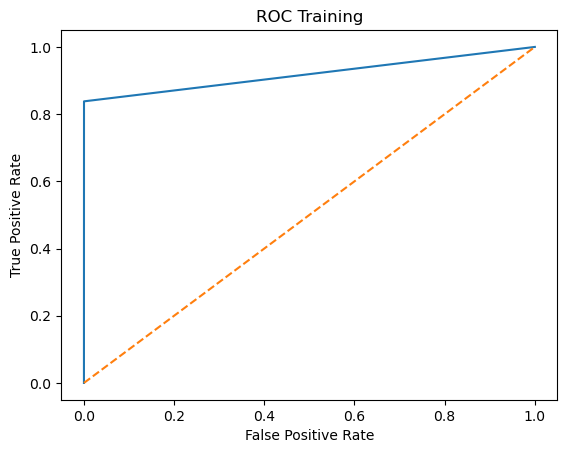

ROC_AUC best alpha with smote case:  0.8715200000000001
AUC:  0.8715200000000001
the confusion matrix:
 [[15610    15]
 [   96   279]]
Misclassification rate: 0.0069375
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     15625
         1.0       0.95      0.74      0.83       375

    accuracy                           0.99     16000
   macro avg       0.97      0.87      0.92     16000
weighted avg       0.99      0.99      0.99     16000



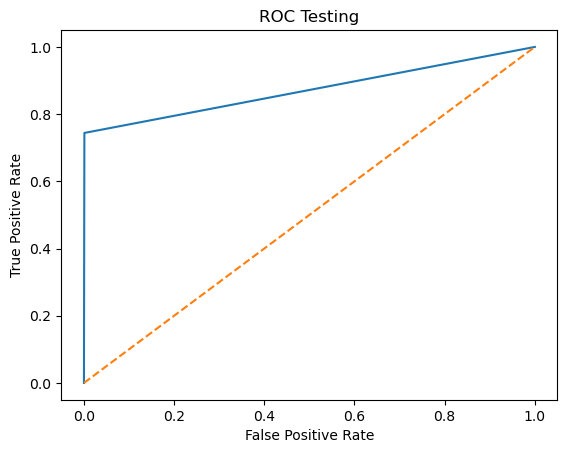

ROC_AUC 0 alpha with smote case:  0.8715200000000001
test error: 0.006937500000000041


In [17]:
#Training#
pred_training = xgbModel.predict(dfTrain_X_smote)

true_training_all = y_smote.apply(lambda x: 0 if x == "neg" else 1)

roc_auc = roc_auc_score(true_training_all, pred_training)
print("ROC_AUC: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_training_all, pred_training)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_training_all, pred_training)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_training_all, pred_training))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Training')
plt.show()

#Testing for best alpha with smote case#
pred_testing = xgbModel.predict(dfTest_X)

roc_auc = roc_auc_score(true_testing, pred_testing)
print("ROC_AUC best alpha with smote case: ", roc_auc)

fpr, tpr, thresholds = roc_curve(true_testing, pred_testing)
print("AUC: ", auc(fpr, tpr))

cm = confusion_matrix(true_testing, pred_testing)
print('the confusion matrix:\n', cm)

misclassification_rate = (cm[0,1] + cm[1,0]) / cm.sum()
print("Misclassification rate: {}".format(misclassification_rate))

print(classification_report(true_testing, pred_testing))

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing')
plt.show()

#Testing for the uncompensated with smote case#
params["alpha"] = 0
xgbClf_0 = XGBClassifier(**params)

xgbModel_smote_0 = xgbClf_0.fit(dfTrain_X_smote, y_smote.apply(lambda x: 0 if x == "neg" else 1))

pred_testing0 = xgbModel.predict(dfTest_X)

roc_auc0 = roc_auc_score(true_testing, pred_testing0)
print("ROC_AUC 0 alpha with smote case: ", roc_auc0)
print("test error: {}".format(1 - accuracy_score(true_testing, pred_testing0)))

The SMOTE method has the lower error rate.

## 2. ISLR 6.6.3

a. iv. Steadily decrease. When s is large enough, the model becomes a least squares regression, more flexible, further reducing variance and decreasing training RSS. 

b. ii. Decrease initially, and then eventually start increasing in a U shape. Increasing s initially leads to decreased Test RSS due to increased model flexibility. However, there comes a point where the increase in variance outweighs the reduction in bias, causing the Test RSS to increase again. As s continues to increase, the model becomes increasingly overfit, and the Test RSS continues to increase.

c. iii. Steadily increase. Increasing s leads to an increase in the model's flexibility, causing an increase in variance. This happens because the coefficients become less restricted, allowing the model to fit the training data more closely.

d. iv. Steadily decrease. Increasing the flexibility of a model through s will generally lead to a decrease in bias. This occurs because as the model becomes more flexible, it can better fit the data and capture complex relationships.

e. v. Remain constant. The irreducible error is a constant error that remains independent of the model's flexibility or the value of s. It is caused by inherent uncertainty or noise in the system being approximated and cannot be reduced by increasing s.

## 3. ISLR 6.6.5

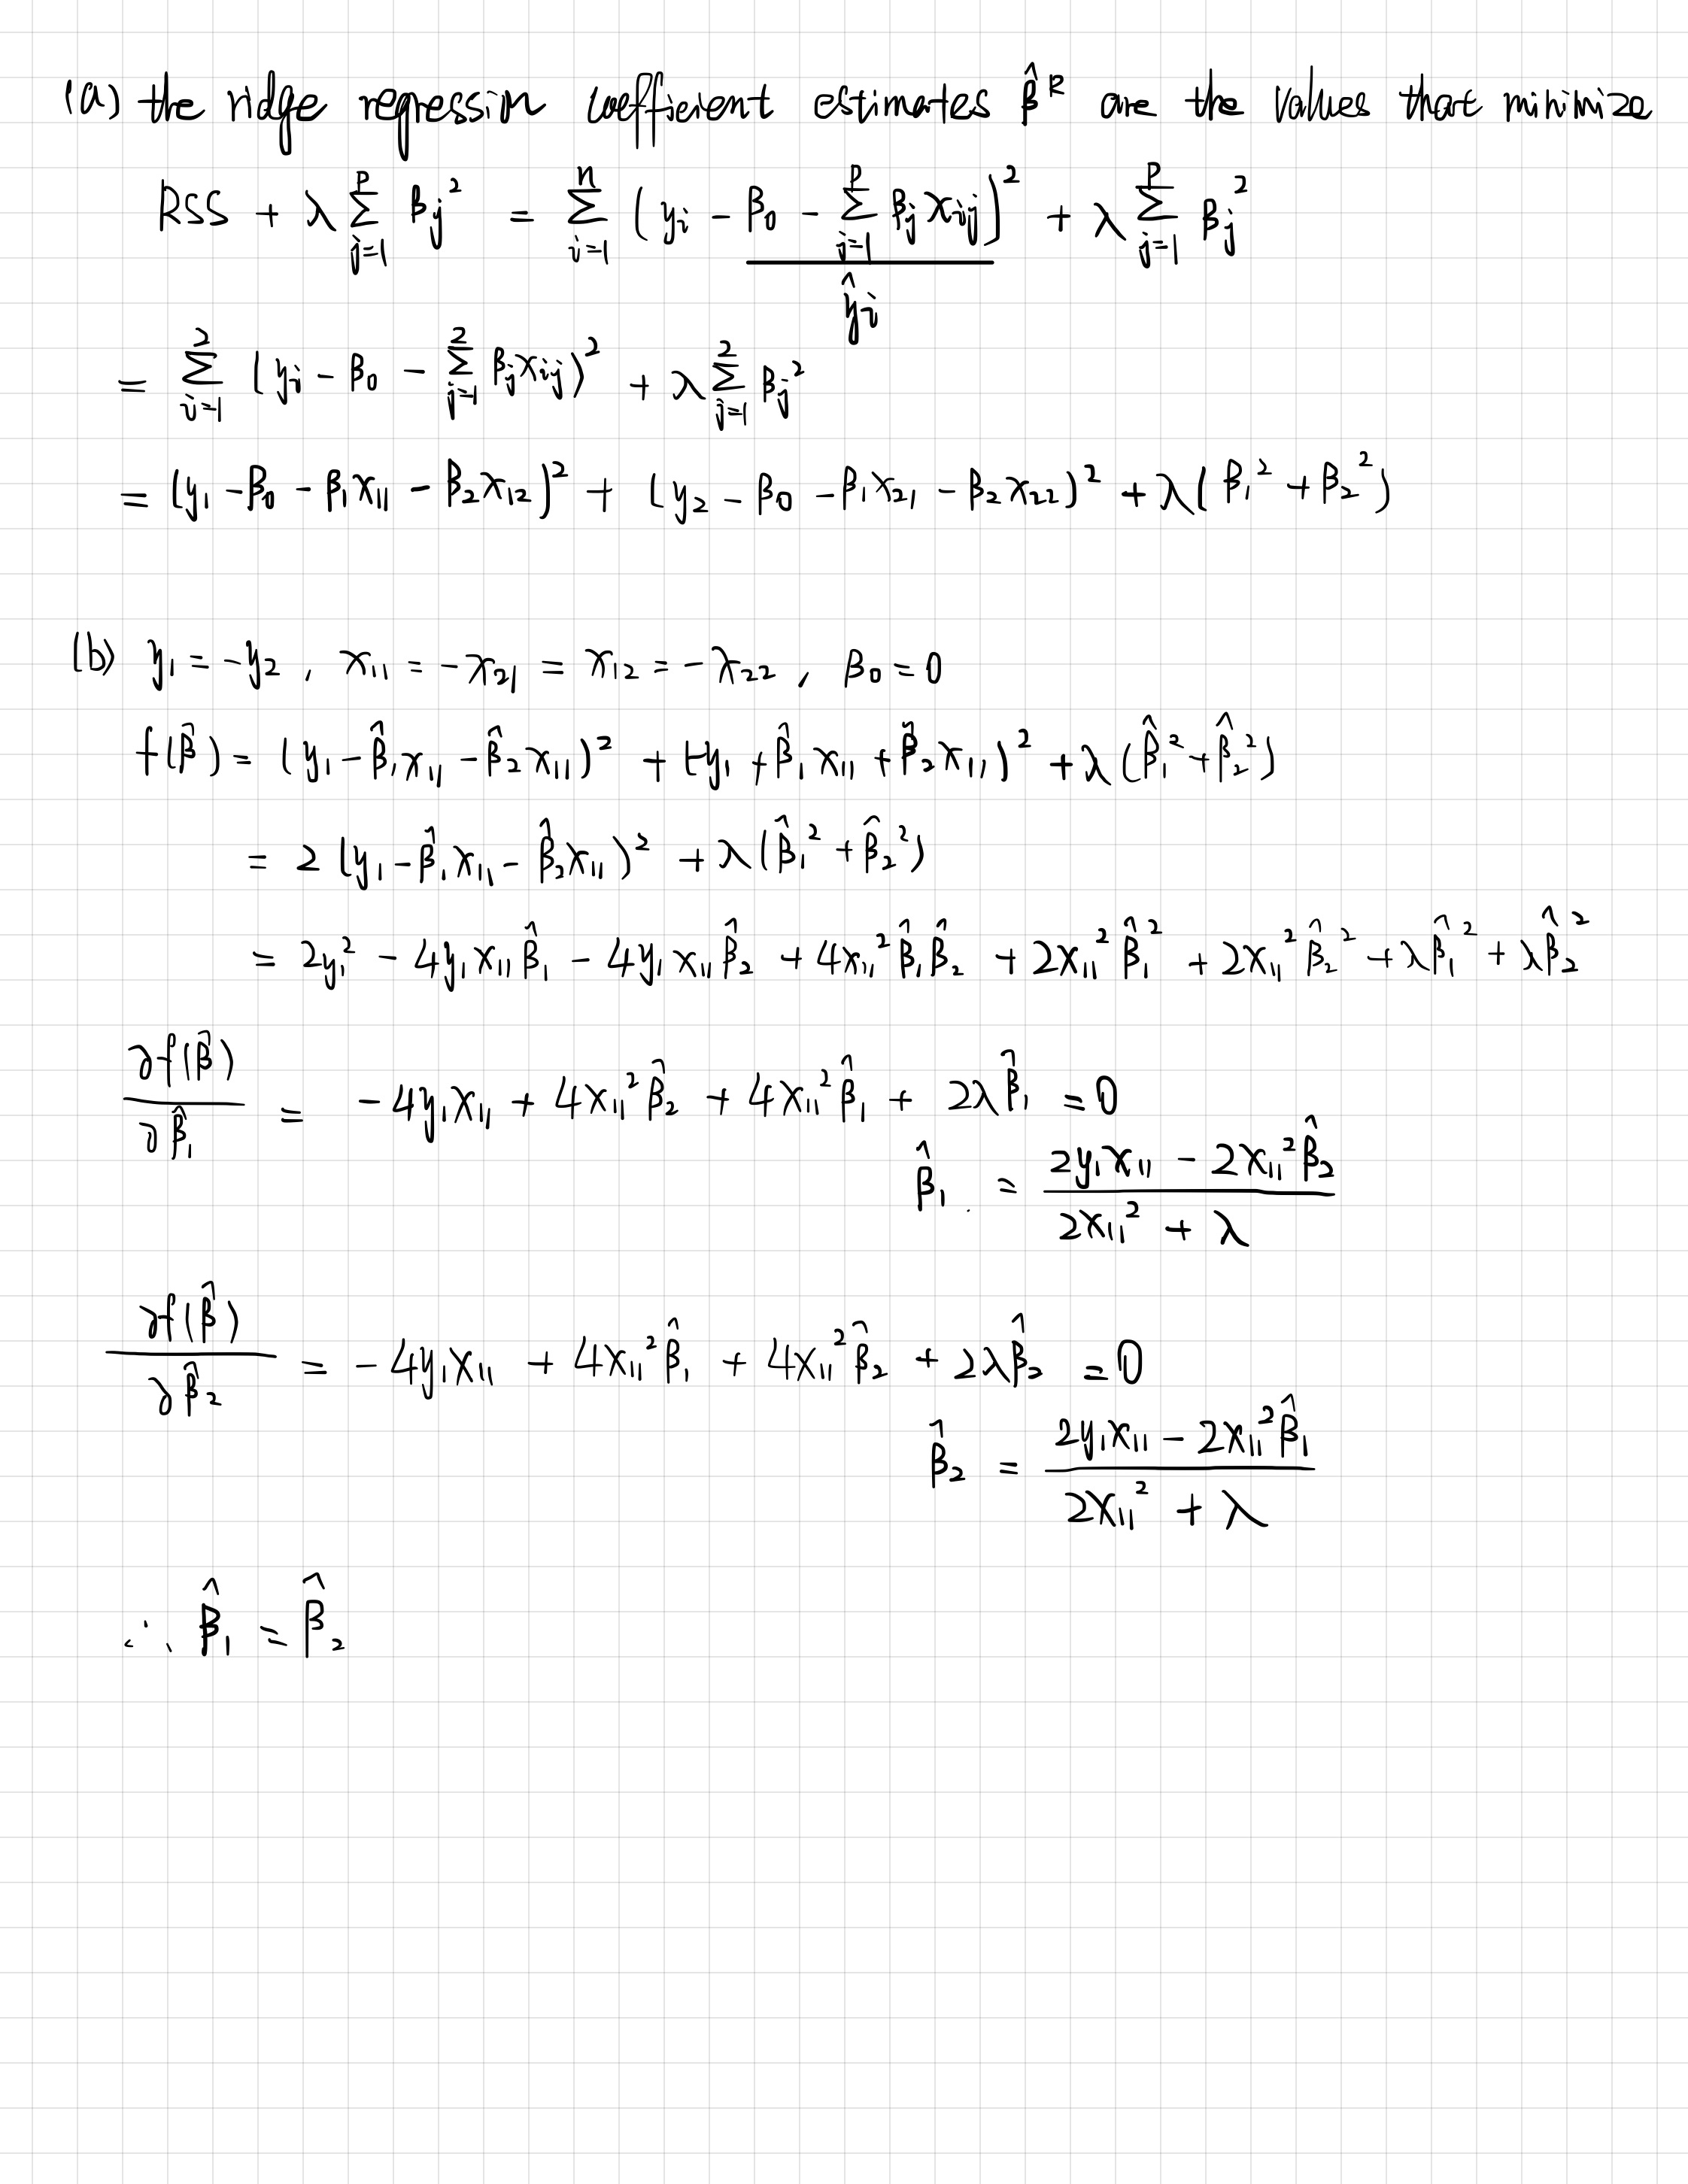

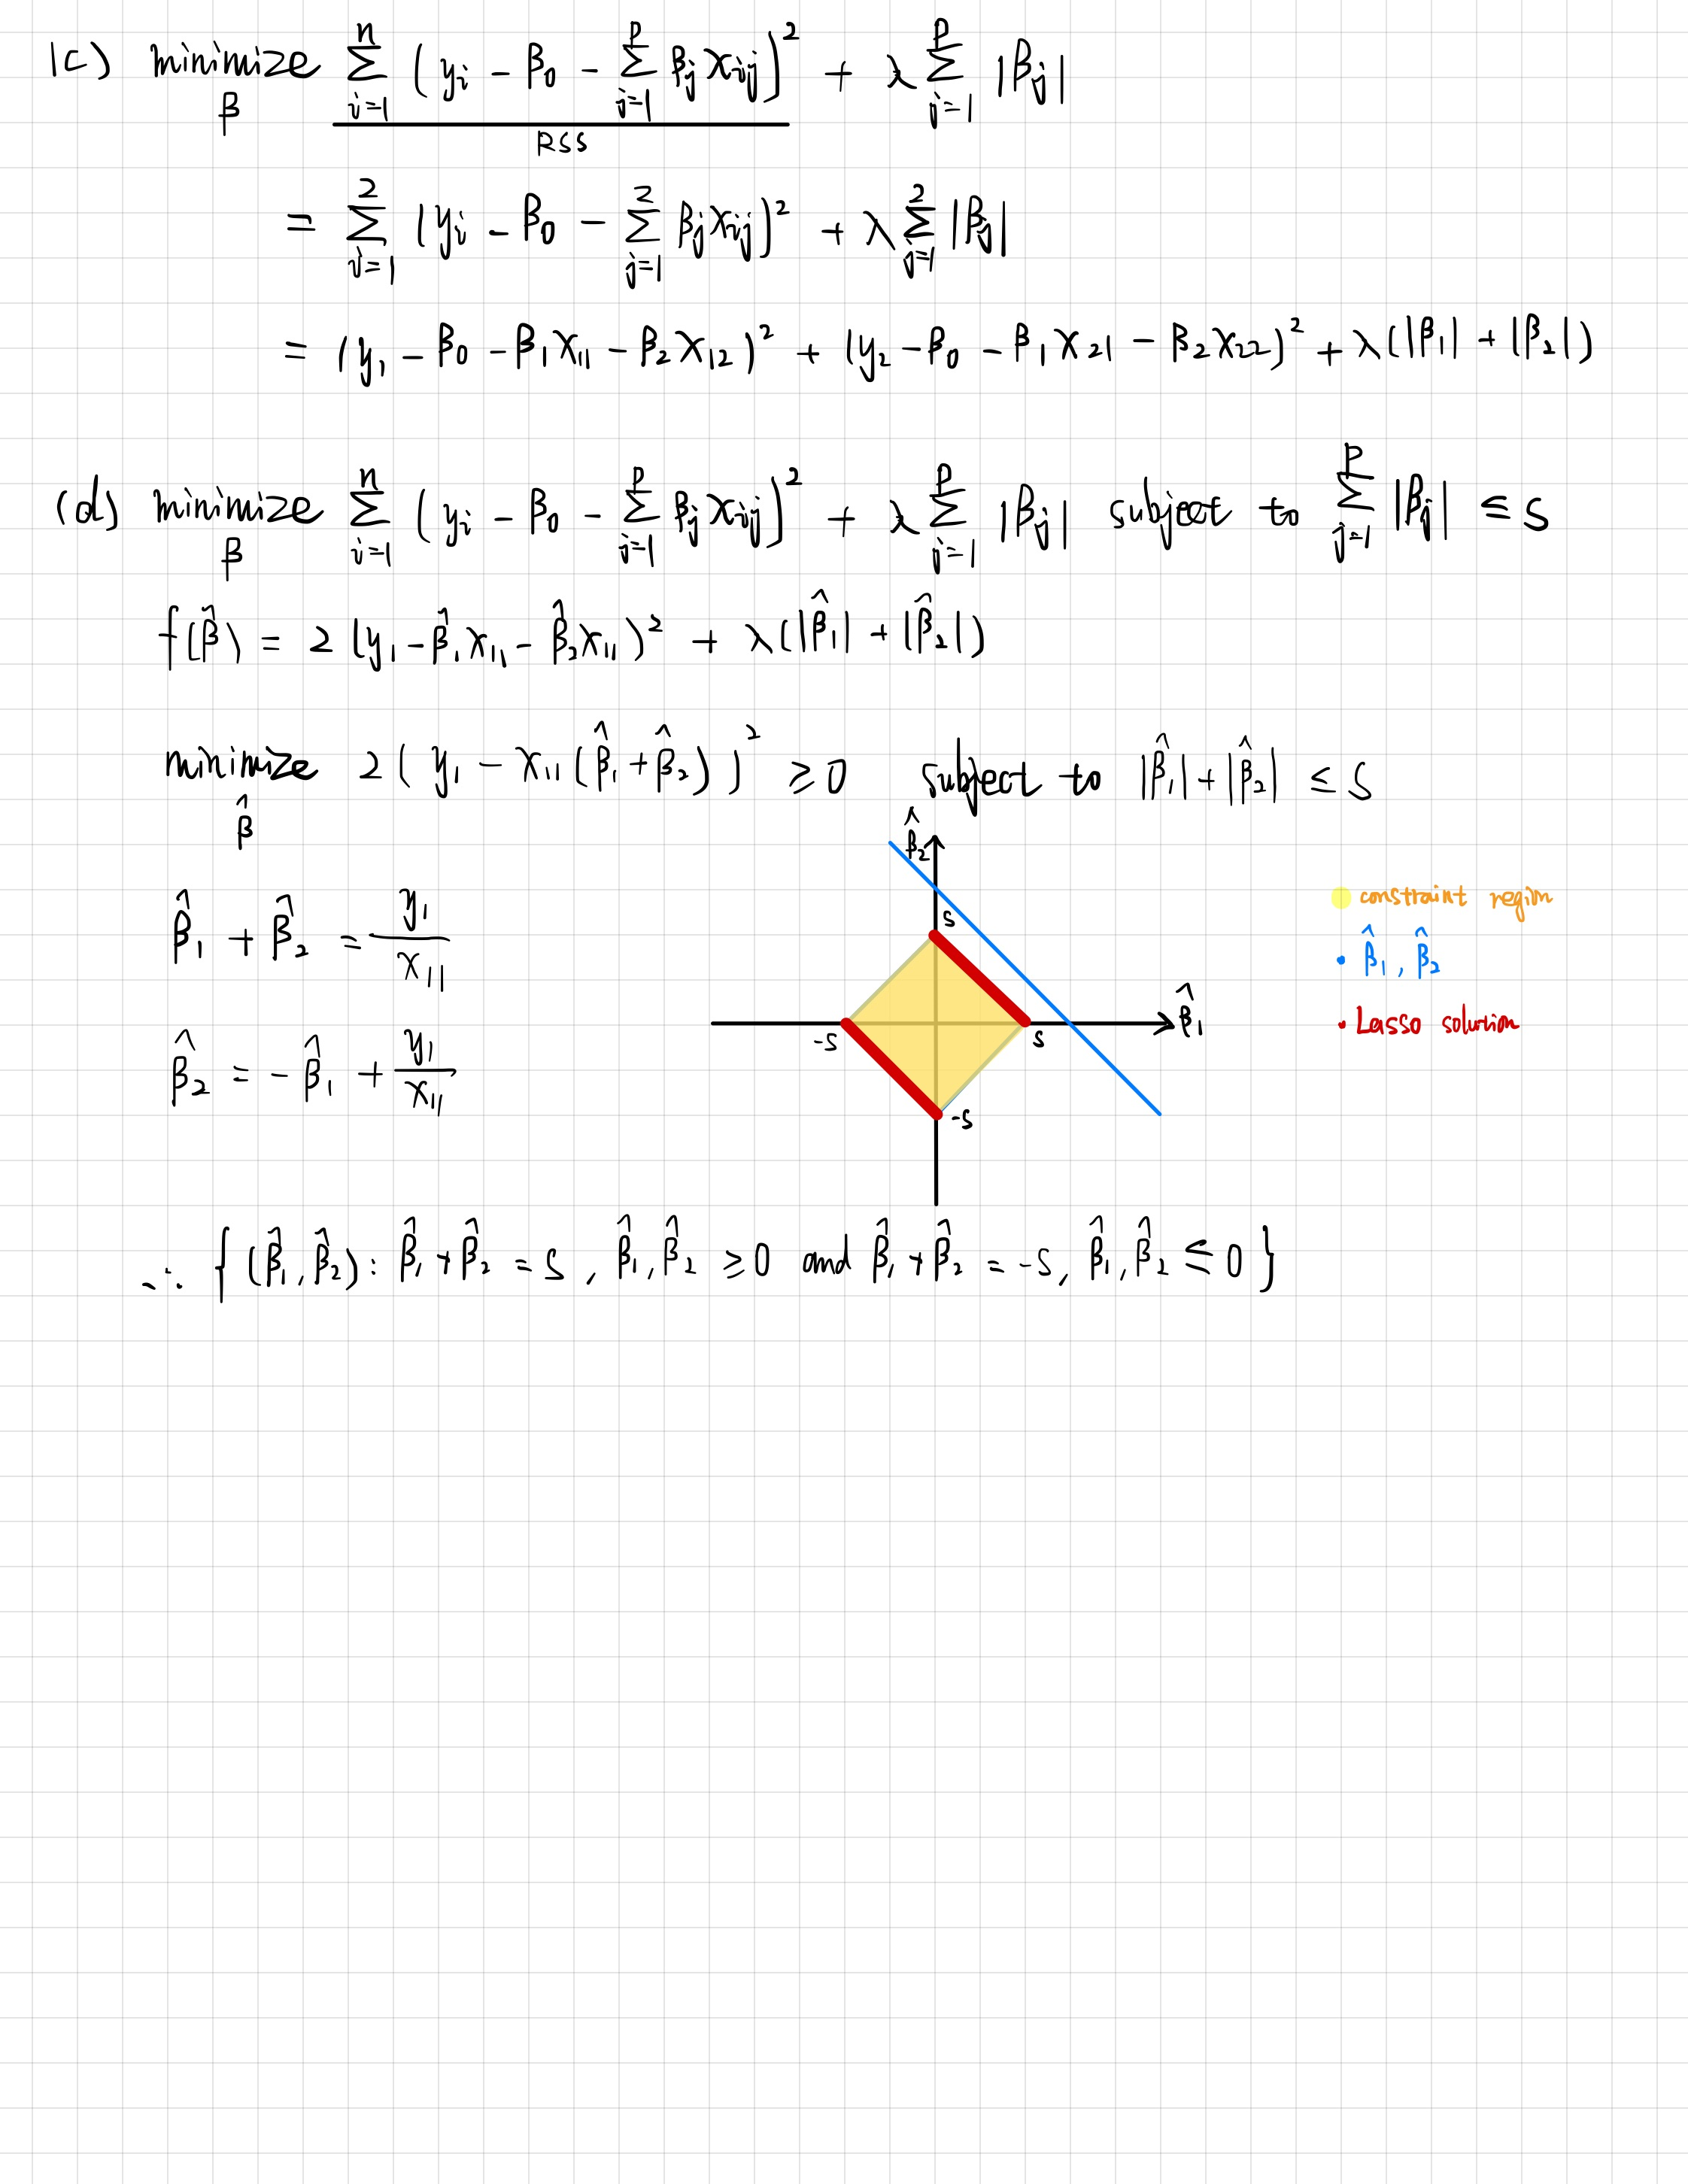

## 4. ISLR 8.4.5

Majortity Vote with probability 0.5 has 4 green predictions and 6 red predictions, thus the final classification is red.

The average probability of P(Class is Red|X) is (0.1+0.15+0.2+0.2+0.55+0.6+0.6+0.65+0.7+0.75)/10 = 0.45 < 0.5, thus the final classification is green.

## 5. ISLR 9.7.3

(a) Sketch the observations.

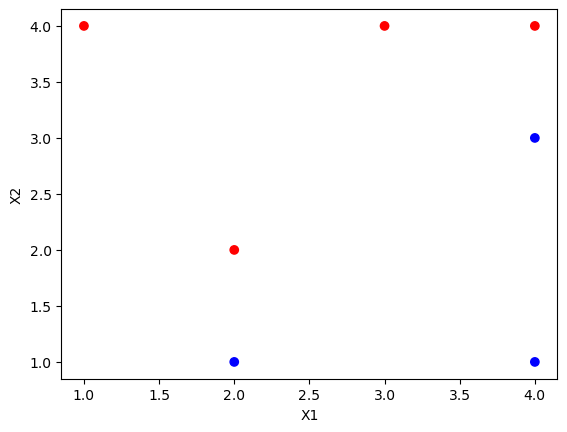

In [18]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

plt.scatter(x1, x2, c = y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1)).

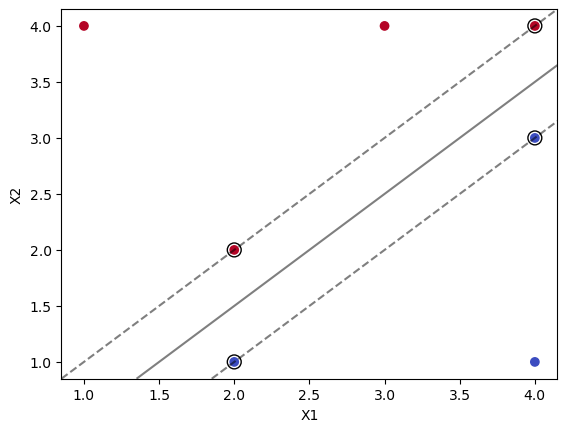

In [19]:
from sklearn.svm import SVC

y = np.where(np.array(y) == 'Red', 1, 0)

clf = SVC(kernel = 'linear', C=10)
clf.fit(np.column_stack((x1, x2)), y)

plt.scatter(x1, x2, c = y, cmap='coolwarm')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
XX, YY = np.meshgrid(xx, yy)
xy = np.column_stack((XX.ravel(), YY.ravel()))
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

The equation for this hyperplane: X1-X2-0.5 = 0

(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines of “Classify to Red if β0 + β1X1 + β2X2 > 0, and classify to Blue otherwise.” Provide the values for β0, β1, and β2.

Classify to Red if -0.5 + X1 - X2 > 0

Classify to Blue if -0.5 + X1 - X2 <= 0

(β0,β1,β2)=(-0.5, 1, -1)

(d) On your sketch, indicate the margin for the maximal margin hyperplane.

The margin can be seen as the area between the dotted and dashed lines on either side of the solid black line, which represents the decision boundary.

(e) Indicate the support vectors for the maximal margin classifier.

(2,1), (2,2), (4,3), (4,4)

(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane.

Because the seventh observation is not a support vector, it does not affect the position of the hyperplane in any significant way. 

(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

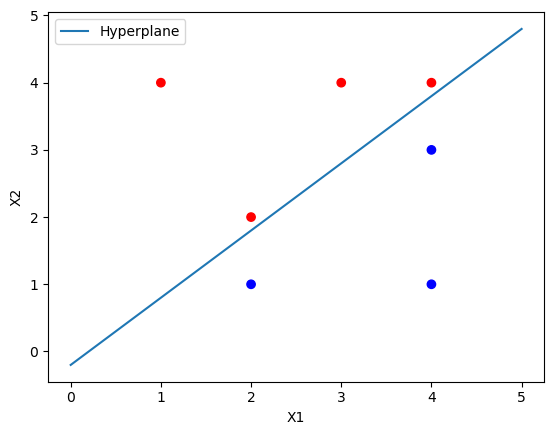

In [20]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']
plt.scatter(x1, x2, c = y)

w1 = -1.00
w2 = 1.00
b = 0.2

x_values = [0, 5]
y_values = [(-b - w1*x1i)/w2 for x1i in x_values]
plt.plot(x_values, y_values, label='Hyperplane')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

The equation for this hyperplane: X1-X2-0.2 = 0

(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane.

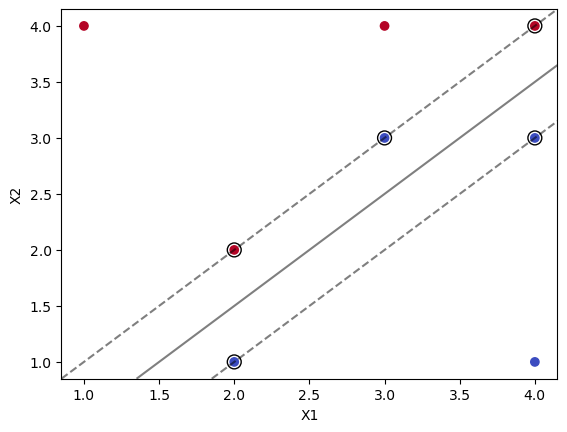

In [21]:
x1 = [3, 2, 4, 1, 2, 4, 4]
x2 = [4, 2, 4, 4, 1, 3, 1]
y = ['Red', 'Red', 'Red', 'Red', 'Blue', 'Blue', 'Blue']

# Add an additional observation that makes the two classes no longer separable by a hyperplane
x1.append(3)
x2.append(3)
y.append('Blue')

y_binary = np.where(np.array(y) == 'Red', 1, 0)

clf = SVC(kernel='linear', C=10)
clf.fit(np.column_stack((x1, x2)), y_binary)

plt.scatter(x1, x2, c=y_binary, cmap='coolwarm')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
XX, YY = np.meshgrid(xx, yy)
xy = np.column_stack((XX.ravel(), YY.ravel()))
Z = clf.decision_function(xy).reshape(XX.shape)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
          linestyles=['--', '-', '--'])
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()